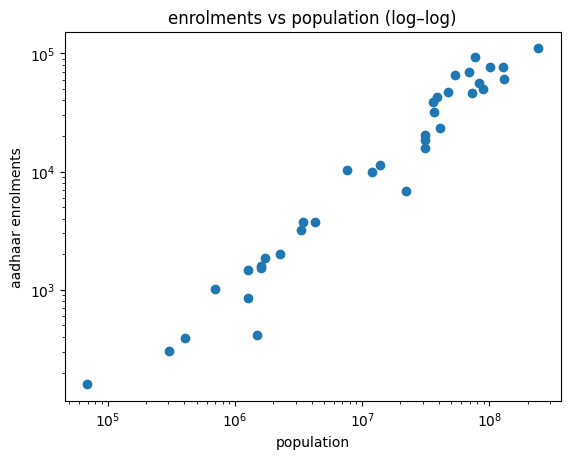

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# load enrolment data
enrolment_df=pd.read_parquet("../sql/data/data_cache/enrolment_clean.parquet")

# normalize state names (using your earlier logic)
enrolment_df["state"]=enrolment_df["state"].apply(normalize_state)

enrolments=(
    enrolment_df
    .dropna(subset=["state"])
    .groupby("state")
    .size()
    .rename("enrolments")
    .reset_index()
)

# load population (try both)
try:
    population=pd.read_csv("../sql/data/clean_population.csv")
except:
    population=pd.read_csv("../sql/data/Population of Indian states 2025.csv")

population.columns=population.columns.str.lower()

# normalize state names in population
population=population.rename(columns={
    population.columns[0]:"state",
    population.columns[1]:"population"
})

population["state"]=population["state"].apply(normalize_state)
population["population"]=pd.to_numeric(population["population"],errors="coerce")

population=population.dropna(subset=["state","population"])

# merge
df=enrolments.merge(population,on="state",how="inner")

# strict log-safe filter
df=df.replace([0,float("inf"),-float("inf")],pd.NA).dropna()
df=df[(df["enrolments"]>0)&(df["population"]>0)]

# guard: plot only if data exists
if not df.empty:
    plt.figure()
    plt.scatter(df["population"],df["enrolments"])
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("population")
    plt.ylabel("aadhaar enrolments")
    plt.title("enrolments vs population (log–log)")
    plt.show()
else:
    print("no valid data after state normalization and filtering")
